In [1]:
# !uv pip install langchain langgraph requests langchain-google-genai pygraphviz

### Setup and Dependencies

In [ ]:
import os
from typing import TypedDict, Optional
import operator

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import StateGraph, END

# Set your Google API key (replace with your actual key or load from .env)
os.environ["GOOGLE_API_KEY"] = ""

# Initialize the Gemini model we'll use for all nodes
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

### Define AI Agent's State

In [3]:
class AgentState(TypedDict, total=False):
    query: str
    answer: Optional[str]
    critique: Optional[str]
    refined: Optional[str]

### Define Prompts

In [4]:
generate_prompt = ChatPromptTemplate.from_template(
    "You are a helpful assistant. Answer the following query:\n\n{query}"
)

reflect_prompt = ChatPromptTemplate.from_template(
    "Here is the assistant's answer:\n\n{answer}\n\nPlease critique it and suggest improvements."
)

refine_prompt = ChatPromptTemplate.from_template(
    "Original answer:\n{answer}\n\nCritique:\n{critique}\n\nPlease provide a refined, improved answer."
)

# Chains together
generate_chain = generate_prompt | llm
reflect_chain = reflect_prompt | llm
refine_chain = refine_prompt | llm

### Define Node Function

In [5]:
def generate_node(state: AgentState):
    result = generate_chain.invoke({"query": state["query"]})
    state["answer"] = result.content
    return state

def reflect_node(state: AgentState):
    result = reflect_chain.invoke({"answer": state["answer"]})
    state["critique"] = result.content
    return state

def refine_node(state: AgentState):
    result = refine_chain.invoke({
        "answer": state["answer"],
        "critique": state["critique"]
    })
    state["refined"] = result.content
    return state

### Build Graph

In [6]:
graph = StateGraph(AgentState)

# Add Node
graph.add_node("generate", generate_node)
graph.add_node("reflect", reflect_node)
graph.add_node("refine", refine_node)

# Set Entry Node
graph.set_entry_point("generate")

# Connect Node (Add a Arrow to connect A Node and B Node)
## "Generate" --> "Reflect"
graph.add_edge("generate", "reflect")
## "Reflect" --> "Refine"
graph.add_edge("reflect", "refine")
## "Refine" --> "END"
graph.add_edge("refine", END)

# Compile
app = graph.compile()

### Run Agent

In [12]:
inputs = {"query": "Tell me what is stochastic gradient descent in 2 sentences"}

for output in app.stream(inputs):
    for node, state in output.items():
        print(f"Output from node '{node}':")

        if node == "generate":
            print(state["query"])
            print(state["answer"])
            print()
        elif node == "reflect":
            print(state["critique"])
            print()
        elif node == "refine":
            print(state["refined"])
            print()

Output from node 'generate':
Tell me what is stochastic gradient descent in 2 sentences
Stochastic Gradient Descent (SGD) is an optimization algorithm that estimates the gradient of the loss function using a *single randomly selected training example* at each step, rather than the entire dataset. This makes it computationally efficient for very large datasets, as it provides frequent updates and can help escape local minima, albeit with noisier and less stable parameter adjustments.

Output from node 'reflect':
The current answer is good, but it has one significant point of inaccuracy/misleading information regarding the "single randomly selected training example" and could benefit from more context and a clearer distinction between the theoretical definition and practical usage.

Here's a critique and suggested improvements:

---

### Critique of the Original Answer:

1.  **"Single randomly selected training example"**: This is the most critical point. While the *purest, original defi

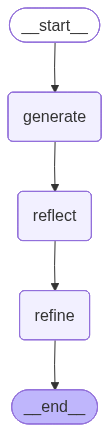

In [11]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())